In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt

### regression

Let's start by using `keras` to make a neural network for a simple regression task where both the input and the output as 1-dimensional. Below is some code that will produce the dataset for you to train on.

Here are some general steps to follow:
1. Define your model by passing `tfk.Sequential` a list of layers (found in `tf.keras.layers`, which is already imported for you by the shorter name `tfkl`, since you will use this module many times.
2. Your first layers should be a `tfkl.Input` layer that specifies the shape of the input (it will automatically include an empty first dimension with size `None` as a placehold for the batch size).
3. The rest of your layers should be `tfkl.Dense` layers; you will be to specify the number of neurons/units as well as the activation function (you can find those in `tf.nn`, and you can use `None` for a "linear" activation function, $f(x)=x$). Make sure you pick an output function that makes sense for this prediction task!
4. Choose an appropriate optimizer from `tfk.optimizers` and an appropriate loss function from `tfk.losses` (both are classes that wil need to be initialized), and then pass them to `model.compile` to compile your model.
5. Call `model.fit` to fit your model and collect the results
6. Plot your training curve (loss vs training step)
7. Call your model (`model(...)`) on a grid of inputs (code to make the grid provided) and plot the relationship your model learned against the true relationship (defined as `f` in the code below).

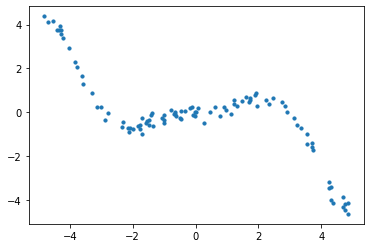

In [25]:
def regression_data(N):
    x = np.random.uniform(low=-5.0, high=5.0, size=(N, 1)).astype(np.float32)
    e = 0.2 * np.random.normal(size=(N, 1)).astype(np.float32)
    f = lambda x: 0.2 * x**2 * np.sin(2 * np.pi * x / 6)
    y = f(x) + e
    return x, y

N = 100
x, y = regression_data(N)

plt.scatter(x, y, s=10)
plt.show()

In [48]:
model = tfk.Sequential(
    [
        tfkl.Input(shape=(1,)), #input layer
        tfkl.Dense(6, activation=tf.nn.tanh),
        tfkl.Dense(6, activation=tf.nn.tanh),
        tfkl.Dense(1, activation=None) #output layer: linear activation function
    ]
)

model.compile(optimizer=tfk.optimizers.Adam(), loss=tfk.losses.MeanSquaredError(), metrics=["mae", "acc"])

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(x,y,epochs=1000,batch_size=x.shape[0],verbose=0)

In [51]:
x_grid = np.linspace(x.min(), x.max(), 200).astype(np.float32)[:, np.newaxis]
y_fit = model(x_grid)

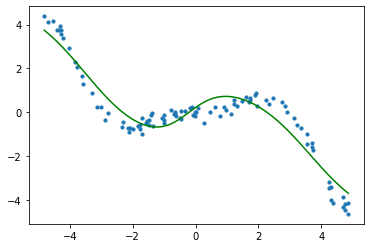

In [54]:
plt.scatter(x, y, s=10)
plt.plot(x_grid,y_fit,color="green")
plt.show()

### binary classification

Here is another dataset that differs in two key ways from the regression example we just worked:
1. The input is now 2-dimensional
2. The targets are now binary classes

Update your model to handle both of these changes and try fitting this new data. Think about the following:
- input shape
- output function
- loss function

Since visualizing the results is a bit tricky, we have provided some code for that.

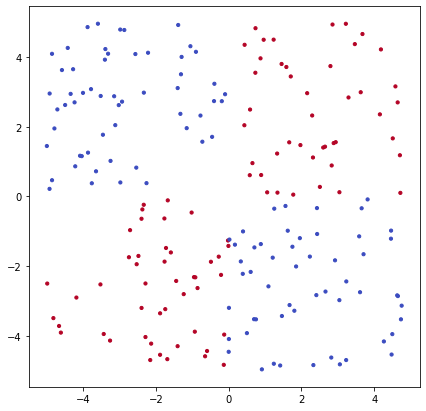

In [55]:
N = 200
def binary_classification_data(N):
    x = np.random.uniform(low=-5, high=5, size=(N, 2))
    y = (x[:, 0] * x[:, 1] > 0).astype(np.int)
    return x, y

x_train, y_train = binary_classification_data(N)
x_test, y_test = binary_classification_data(N)

plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train, cmap='coolwarm')
plt.show()

In [65]:
model = tfk.Sequential(
    [
        tfkl.Input(shape=(2,)), #input layer
        tfkl.Dense(100, activation=tf.nn.softplus),
        tfkl.Dense(20, activation=tf.nn.softplus),
        tfkl.Dense(1, activation=tf.nn.sigmoid) #output layer: linear activation function
    ]
)

model.compile(optimizer=tfk.optimizers.Adam(), loss=tfk.losses.BinaryCrossentropy())

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_30 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [68]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=1)]

ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).repeat().batch(N).prefetch(10)
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).repeat().batch(N).prefetch(10)

results = model.fit(ds_train,steps_per_epoch=100,epochs=100,validation_data=ds_test,
                    validation_steps=1,callbacks=cbs)

Epoch 1/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6099 - val_loss: 0.4476
Epoch 2/100
100/100 [==============================] - 0s 897us/step - loss: 0.2984 - val_loss: 0.2048
Epoch 3/100
100/100 [==============================] - 0s 858us/step - loss: 0.1521 - val_loss: 0.1263
Epoch 4/100
100/100 [==============================] - 0s 856us/step - loss: 0.0978 - val_loss: 0.0942
Epoch 5/100
100/100 [==============================] - 0s 870us/step - loss: 0.0717 - val_loss: 0.0774
Epoch 6/100
100/100 [==============================] - 0s 872us/step - loss: 0.0565 - val_loss: 0.0666
Epoch 7/100
100/100 [==============================] - 0s 865us/step - loss: 0.0465 - val_loss: 0.0589


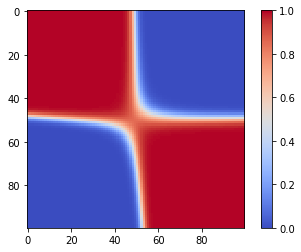

In [69]:
def binary_preds(model, x_minmax=5):
    x_grid = np.linspace(-x_minmax, x_minmax, 100)
    mesh = np.meshgrid(x_grid, x_grid)
    xs_grid = np.stack(mesh, axis=-1)
    yhat = model(xs_grid).numpy().squeeze()
    
    plt.imshow(yhat, cmap='coolwarm')
    plt.colorbar()

binary_preds(model)

### general classfication

Finally we will download and train on some real data to learn about general classification. Here is some code that will download and show some metadata about the MNIST dataset -- a collectin of handwritten digits.

Update your model to work on this data so that you model can predict the digit from its image. One new thing to keep in mind: these inputs are 2D. Later in the course we will learn about convolutional neural nets for handing such inputs more naturally, but for now, update your `tfkl.Input` layer to be 2-dimensional and then add a `tfkl.Flatten()` layer right after it to unravel the 2-d image into a 1-d vector of pixels.

Again, visualalizing the output is a bit tricky, so we have provided some code to help.

In [71]:
import tensorflow_datasets as tfds

ds, metadata = tfds.load('mnist', with_info=True)
print(metadata)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /Users/jianingsun/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [75]:
# your code here
a = tf.nn.softplus
model = tfk.Sequential([
    tfkl.Input((28, 28)),
    tfkl.Flatten(),
    tfkl.Dense(100, activation = a),
    tfkl.Dense(20, activation = a),
    tfkl.Dense(10,activation =tf.nn.softmax)
])

model.summary()

model.compile(optimizer = tfk.optimizers.Adam(), loss = tfk.losses.SparseCategoricalCrossentropy())

cbs = [tfk.callbacks.EarlyStopping(min_delta = 0.01, patience = 1)]

preprocess = lambda d:(tf.cast(d['image'], tf.float32)/255, d['label'])
ds_train = ds['train'].map(preprocess).cache().repeat().batch(32).repeat().prefetch(10)
ds_test =  ds['test'].take(1000).map(preprocess).repeat().batch(1000).repeat().prefetch(10)

result = model.fit(ds_train, steps_per_epoch = 100, epochs = 1000, callbacks= cbs,
               validation_data = ds_test, validation_steps = 1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_36 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                210       
Total params: 80,730
Trainable params: 80,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
100/100 [==============================] - 0s 4ms/step - loss: 1.3629 - val_loss: 0.5932
Epoch 2/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.5302 - val_loss: 0.4312
Epoch 3/1000
100/100 [======================

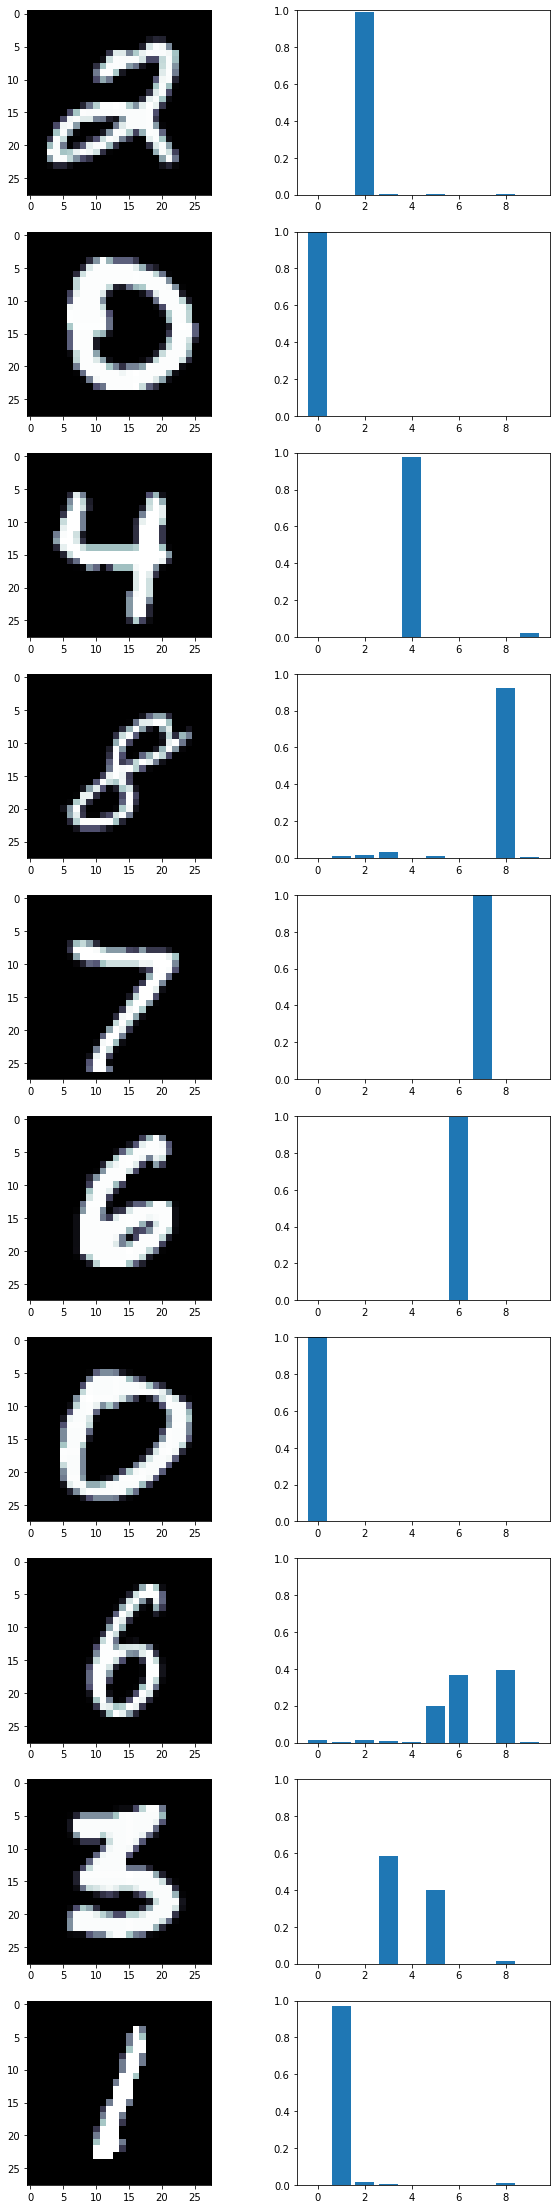

In [79]:
def mnist_viz(model):
    ims, labels = next(iter(ds['test'].map(preprocess).batch(10)))
    yhat = model(ims)
    ypred = tf.argmax(yhat)
    
    plt.figure(figsize=(10, 40))
    for i in range(10):
        plt.subplot(10, 2, 2*i+1)
        plt.imshow(ims[i].numpy().squeeze(), cmap='bone')
        plt.subplot(10, 2, 2*i+2)
        plt.bar(np.arange(10), yhat[i].numpy())
        plt.ylim([0, 1])
    plt.show()

# your code here
mnist_viz(model)